In [1]:
# Load the necessary libraries
import numpy as np
import sympy as sp
from sympy.physics.mechanics import dynamicsymbols
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# This is for pretty printing
import IPython.display as disp

Constants

In [2]:
# Cell 3: Define physical constants for the system
m1_crank_val, m2_val, m3_val = 1.0, 2.0, 0.5  # Masses (kg) - m1_crank_val is mass of crank arm
L1_val, L2_val = 0.5, 1.5                   # Lengths (m)
I1_crank_val, I2_val = 0.1, 1.5             # Moments of Inertia (kg*m^2) - I1_crank_val is for crank arm about its CoM
F0_val = 50                                 # Force amplitude (N)
k_val = 1                                   # Damping coefficient for crank (Nms/rad)
g_val = 9.81                                # Gravity (m/s^2)

# Flywheel Properties
m_flywheel_val = 5.0 # Mass of the flywheel (kg) - its CoM is at pivot, so its gravity doesn't create torque
r_flywheel_val = 0.5 # Radius of the flywheel (m)
I_flywheel_val = 0.5 * m_flywheel_val * r_flywheel_val**2 # Moment of inertia of flywheel about pivot (kg*m^2)

# --- REMOVED: Gearing Ratio ---

In [3]:
# Cell 4: Define symbolic variables and system matrices
t = sp.symbols('t')
# theta_fw is still a distinct DOF for the flywheel's rotation
x1, x2, y1, y2, theta1, theta2, x3, y3, theta_fw = dynamicsymbols('x1 x2 y1 y2 theta1 theta2 x3 y3 theta_fw')
q = sp.Matrix([x1, y1, theta1, x2, y2, theta2, x3, y3, theta_fw]) # q still has 9 elements
dq = q.diff(t)

x_com_1 = sp.Matrix([x1, y1])
x_com_2 = sp.Matrix([x2, y2])
x_com_3 = sp.Matrix([x3, y3])

R = lambda theta: sp.Matrix([[sp.cos(theta), -sp.sin(theta)], [sp.sin(theta), sp.cos(theta)]])

# Mass Matrix includes the flywheel's rotational inertia
M_np = np.diag([m1_crank_val, m1_crank_val, I1_crank_val,    # Body 1 (crank arm)
                m2_val, m2_val, I2_val,                    # Body 2 (conrod)
                m3_val, m3_val,                            # Body 3 (piston trans DoFs)
                I_flywheel_val])                           # DOF for flywheel rotation (theta_fw)

W_np = np.linalg.inv(M_np)

# Q (Generalized forces) - no direct external torque on flywheel DOF theta_fw
Q = sp.Matrix([0,
               -m1_crank_val * g_val,  # Gravity on crank arm CoM
               -k_val * theta1.diff(t), # Damping/load on crankshaft
               0,
               -m2_val * g_val,         # Gravity on conrod
               0,
               0,
               -m3_val * g_val + F0_val * sp.cos(theta1), # Piston forces
               0])                      # No direct external torque on flywheel DOF

In [4]:
# Cell 5: Define constraint equations
i_cap = sp.Matrix([1, 0])
j_cap = sp.Matrix([0, 1])

# Crank pivot at origin
constraint_1 = x_com_1 + R(theta1) @ sp.Matrix([-L1_val/2, 0])
C1 = constraint_1.dot(i_cap)
C2 = constraint_1.dot(j_cap)

# Pin joint: crank - conrod
constraint_2 = (x_com_1 + R(theta1) @ sp.Matrix([L1_val/2, 0])) - \
               (x_com_2 + R(theta2) @ sp.Matrix([-L2_val/2, 0]))
C3 = constraint_2.dot(i_cap)
C4 = constraint_2.dot(j_cap)

# Pin joint: conrod - piston
constraint_3 = (x_com_2 + R(theta2) @ sp.Matrix([L2_val/2, 0])) - x_com_3
C5 = constraint_3.dot(i_cap)
C6 = constraint_3.dot(j_cap)

# Piston slides vertically
constraint_4 = x_com_3[0]
C7 = constraint_4

# --- MODIFIED: Direct Coupling Constraint ---
# theta_fw = theta1 (flywheel rotates with crank)
# So, theta_fw - theta1 = 0
C_direct_coupling = theta_fw - theta1
C8 = C_direct_coupling
# --- END MODIFICATION ---

C = sp.Matrix([C1, C2, C3, C4, C5, C6, C7, C8]) # C still has 8 constraint equations

In [ ]:
# Cell 6: Formulate terms for DAE solution and lambdify
J = C.jacobian(q) # J is 8x9

# --- MODIFICATION: Use J.diff(t) for dJ/dt which is more standard for (dJ/dt)dq term ---
dC_dt_expr = J @ dq # This is dC/dt
dJ_dt_expr = J.diff(t) # This computes dJ/dt where J contains dynamic symbols q(t)
dJ_times_dq_dt_expr = dJ_dt_expr @ dq # This is (dJ/dt) * dq
# --- END MODIFICATION ---

W_sym = sp.MatrixSymbol('W_matrix', M_np.shape[0], M_np.shape[1]) # Shape is 9x9

# Baumgarte stabilization parameters (can be tuned)
alpha_baumgarte = 10 
beta_baumgarte = 10

# --- MODIFICATION: Use dC_dt_expr in RHS_sym ---
RHS_sym = -dJ_times_dq_dt_expr - J @ W_sym @ Q - beta_baumgarte * dC_dt_expr - alpha_baumgarte * C
# --- END MODIFICATION ---

JWJT_fn = sp.lambdify(args=(q, dq, W_sym), expr=(J @ W_sym @ J.T), modules=['numpy', 'sympy'])
RHS_fn = sp.lambdify(args=(q, dq, W_sym), expr=RHS_sym, modules=['numpy', 'sympy'])

C_fn_num = sp.lambdify(args=(q,), expr=C, modules=['numpy', 'sympy'])
J_fn_num = sp.lambdify(args=(q,), expr=J, modules=['numpy', 'sympy'])
Q_fn_num = sp.lambdify(args=(q, dq), expr=Q, modules=['numpy', 'sympy'])
# --- MODIFICATION: Lambdify dC_dt_expr, rename for clarity ---
dC_dt_fn_num = sp.lambdify(args=(q, dq), expr=dC_dt_expr, modules=['numpy', 'sympy'])
# --- END MODIFICATION ---

In [6]:
# Cell 7: Set up and refine initial conditions
dtheta1_init = 0.5 # rad/s

# --- MODIFICATION: theta_fw starts aligned with theta1 (direct coupling) ---
theta1_init_val = np.pi/2
theta_fw_init_val = theta1_init_val # Directly coupled

q_init_guess = np.array([
    0, L1_val/2, theta1_init_val,               # x1, y1, theta1
    0, L1_val + L2_val/2, np.pi/2,              # x2, y2, theta2
    0, L1_val + L2_val,                         # x3, y3
    theta_fw_init_val                           # theta_fw
])
# --- END MODIFICATION ---

C_at_init_pos = C_fn_num(q_init_guess).flatten()
print(f"Initial position constraint violation C(q_init_guess): \n{C_at_init_pos}")
assert np.allclose(C_at_init_pos, 0, atol=1e-6), "Chosen initial positions DO NOT satisfy constraints C=0!"

# --- MODIFICATION: Update velocity_constraint_solver for direct coupling ---
# dq = [dx1, dy1, dtheta1, dx2, dy2, dtheta2, dx3, dy3, dtheta_fw]
# known_dtheta1 is dq[2].
# From dC8/dt = 0: dtheta_fw_dt - dtheta1_dt = 0
# So, dtheta_fw_dt = dtheta1_dt. This is dq[8].
# known_dtheta_fw will be set equal to known_dtheta1.
# The solver finds the other 7: b_vel = [dx1, dy1, dx2, dy2, dtheta2, dx3, dy3]

def velocity_constraint_solver(b_vel, q_pos, known_dtheta1):
    # b_vel has 7 elements
    known_dtheta_fw = known_dtheta1 # Due to direct coupling d(theta_fw - theta1)/dt = 0
    dq_full = np.array([
        b_vel[0], b_vel[1], known_dtheta1,    # dx1, dy1, dtheta1
        b_vel[2], b_vel[3], b_vel[4],    # dx2, dy2, dtheta2
        b_vel[5], b_vel[6],              # dx3, dy3
        known_dtheta_fw                  # dtheta_fw
    ])
    J_num = J_fn_num(q_pos) # J_num is 8x9
    dC_val_all = (J_num @ dq_full).flatten() # Should be 8 zeros
    # We are explicitly setting dtheta_fw_dt based on dtheta1_dt, so dC8/dt should be zero.
    # The solver needs to make the first 7 components of dC_val_all zero.
    return dC_val_all[:7] # Return only the first 7 constraint velocity equations for the 7 unknowns

import scipy.optimize as opt
b_vel_guess = np.zeros(7) # 7 unknowns

# Enforce direct coupling for initial velocities
dtheta_fw_init = dtheta1_init

solution = opt.root(velocity_constraint_solver, b_vel_guess,
                    args=(q_init_guess, dtheta1_init),
                    method='hybr', options={'xtol': 1e-8})

if not solution.success:
    print(f"Warning: Initial velocity optimization might not have converged. Message: {solution.message}")

b_vel_sol = solution.x
dq_init_consistent = np.array([
    b_vel_sol[0], b_vel_sol[1], dtheta1_init,
    b_vel_sol[2], b_vel_sol[3], b_vel_sol[4],
    b_vel_sol[5], b_vel_sol[6],
    dtheta_fw_init # dq[8] is dtheta_fw, now equal to dtheta1_init
])
# --- END MODIFICATION ---

# Verify all constraints
J_num_init = J_fn_num(q_init_guess)
dC_at_init_vel_all = (J_num_init @ dq_init_consistent).flatten()
print(f"Full initial velocity constraint violation dC(q_init, dq_consistent): \n{dC_at_init_vel_all}")
assert np.allclose(dC_at_init_vel_all, 0, atol=1e-6), "Solved initial velocities DO NOT satisfy all dC=0!"

x0 = np.concatenate((q_init_guess, dq_init_consistent))
print("\nConsistent initial state vector x0 (9 positions, 9 velocities):")
print(x0)

Initial position constraint violation C(q_init_guess): 
[-1.5308085e-17  0.0000000e+00  6.1232340e-17  0.0000000e+00
  4.5924255e-17  0.0000000e+00  0.0000000e+00  0.0000000e+00]
Full initial velocity constraint violation dC(q_init, dq_consistent): 
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.43492963e-42 -1.89911355e-65  0.00000000e+00]

Consistent initial state vector x0 (9 positions, 9 velocities):
[ 0.00000000e+00  2.50000000e-01  1.57079633e+00  0.00000000e+00
  1.25000000e+00  1.57079633e+00  0.00000000e+00  2.00000000e+00
  1.57079633e+00 -1.25000000e-01  7.65404249e-18  5.00000000e-01
 -1.25000000e-01  7.65404249e-18 -1.66666667e-01 -1.89911355e-65
  1.43492963e-42  5.00000000e-01]


Calculate initial conditions for the system

In [7]:
# import scipy.optimize as opt
#
# x, _ = np.split(x0, 2)
# def optimiser(b):
#     dx1, dy1, dx2, dy2, dtheta2, dx3, dy3 = b
#     dq = np.array([dx1, dy1, dtheta1, dx2, dy2, dtheta2, dx3, dy3]) # Original had 8 DOFs
#     val = dC_dt_fn_num(x, dq).flatten() # Using corrected dC_dt_fn_num
#     return val
#
# initial_guess = np.array([0, 0, 0, 0, 0, 0, 0])
# result = opt.root(optimiser, initial_guess)
# print(result)
#
# b = result.x
# dx = np.array([b[0], b[1], dtheta1, b[2], b[3], b[4], b[5], b[6]]) # Original had 8 DOFs
#
# C_val_check = C_fn_num(x)
# dC_val_check = dC_dt_fn_num(x, dx)
#
# print(f'Position constraint: {C_val_check}')
# print(f'Velocity constraint: {dC_val_check}')
# assert np.allclose(C_val_check.flatten(), 0, atol=1e-6), "Initial position constraint violated"
# assert np.allclose(dC_val_check.flatten(), 0, atol=1e-6), "Initial velocity constraint violated"
# x0_check = np.concatenate((x, dx))
# x0_check
# This cell was commented out in the original; kept as is with minor internal comment updates.

In [8]:
# Cell 8: Define the function for the DAE solver
def piston_engine_flywheel(t, state):
    q_num, dq_num = np.split(state, 2)

    JWJT_val = JWJT_fn(q_num, dq_num, W_np)
    RHS_val = RHS_fn(q_num, dq_num, W_np).flatten() # Ensure RHS is 1D

    try:
        lam = np.linalg.solve(JWJT_val, RHS_val)
    except np.linalg.LinAlgError:
        print(f"Singular matrix encountered at t={t}. Using pseudo-inverse.")
        lam = np.linalg.pinv(JWJT_val) @ RHS_val

    J_val_num = J_fn_num(q_num)
    Qhat = J_val_num.T @ lam.reshape(-1,1) # Ensure lam is column vector for matmul

    Q_val_num = Q_fn_num(q_num, dq_num)
    ddq = W_np @ (Q_val_num + Qhat) # Q_val_num and Qhat should be (9,1)
    ddq = ddq.flatten()

    return np.concatenate((dq_num, ddq))

# Test run
initial_derivatives = piston_engine_flywheel(0, x0)
print("\nInitial derivatives (dq, ddq) from test run:")
print(initial_derivatives)


Initial derivatives (dq, ddq) from test run:
[-1.25000000e-01  7.65404249e-18  5.00000000e-01 -1.25000000e-01
  7.65404249e-18 -1.66666667e-01 -1.89911355e-65  1.43492963e-42
  5.00000000e-01  1.15830116e-01 -6.25000000e-02 -4.63320463e-01
  1.15830116e-01 -1.45833333e-01  1.54440154e-01 -1.38777878e-17
 -1.66666667e-01 -4.63320463e-01]


In [9]:
# Cell 9: Run the numerical simulation
t_start = 0
t_end = 10 
num_points = 500 

t_span = (t_start, t_end)
t_eval = np.linspace(*t_span, num_points)

print("\nStarting numerical integration...")
sol = solve_ivp(piston_engine_flywheel, t_span, x0,
                atol=1e-7, rtol=1e-7, method='BDF', t_eval=t_eval)
print("Integration finished.")
print(f"Solver status: {sol.message}")
if not sol.success:
    print("Warning: Solver did not terminate successfully.")

# Explanation:
# t_start, t_end, num_points: Parameters for the simulation time.
# t_span: Tuple defining the start and end time of the simulation.
# t_eval: Array of time points where the solution should be stored.
# solve_ivp: Solves the system of DAEs.
#    - piston_engine_flywheel: The function defining the system dynamics.
#    - t_span: Integration interval.
#    - x0: Consistent initial state.
#    - atol, rtol: Absolute and relative error tolerances for the solver.
#    - method='BDF': Uses the Backward Differentiation Formula, good for stiff DAEs.
#    - t_eval: Times at which to store the solution.
# sol: The solution object containing time points (sol.t) and state vectors (sol.y).
# Print statements provide feedback on the integration process.


Starting numerical integration...
Integration finished.
Solver status: The solver successfully reached the end of the integration interval.


Animation

In [10]:
# Class for drawing the box
class Box:
    def __init__(self, width, height, color='b'):
        self.width = width
        self.height = height
        self.color = color
        self.offset = -np.array([width/2, height/2])

    def first_draw(self, ax):
        corner = np.array([0, 0])
        self.patch = plt.Rectangle(corner, 0, 0, angle=0, 
                        rotation_point='center', color=self.color, animated=True)
        ax.add_patch(self.patch)
        self.ax = ax
        return self.patch
    
    def set_data(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta

    def update(self, i):
        x, y, theta = self.x[i], self.y[i], self.theta[i]
        theta = np.rad2deg(theta)

        # The rectangle is drawn from the left bottom corner
        # So, we need to calculate the corner position
        corner = np.array([x, y]) + self.offset

        # Update the values for the rectangle
        self.patch.set_width(self.width)
        self.patch.set_height(self.height)
        self.patch.set_xy(corner)
        self.patch.set_angle(theta)
        return self.patch
    
# Flywheel visual class
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

class FlywheelVisual:
    def __init__(self, radius, color='dimgray', line_color='black', line_angle_offset_rad=0):
        self.radius = radius
        self.color = color
        self.line_color = line_color
        self.line_angle_offset_rad = line_angle_offset_rad # Offset for visual distinction if needed
        self.patch = None
        self.line = None

    def first_draw(self, ax):
        self.patch = Circle((0,0), self.radius, fc=self.color, animated=True, zorder=1)
        ax.add_patch(self.patch)
        self.line = Line2D([0, 0], [0, 0], color=self.line_color, lw=2, animated=True, zorder=2)
        ax.add_line(self.line)
        return [self.patch, self.line]

    def set_data(self, center_x_array, center_y_array, theta_flywheel_array):
        self.center_x_array = center_x_array
        self.center_y_array = center_y_array
        self.theta_flywheel_array = theta_flywheel_array # This is the flywheel's own angle

    def update(self, i):
        cx = self.center_x_array[i]
        cy = self.center_y_array[i]
        self.patch.center = (cx, cy)
        
        # Line rotates with theta_flywheel, offset is for visual distinction
        th_flywheel_effective = self.theta_flywheel_array[i] + self.line_angle_offset_rad
        
        line_start_x = cx
        line_start_y = cy
        line_end_x = cx + self.radius * np.cos(th_flywheel_effective)
        line_end_y = cy + self.radius * np.sin(th_flywheel_effective)
        
        self.line.set_data([line_start_x, line_end_x], [line_start_y, line_end_y])
        
        return [self.patch, self.line]

In [11]:
# Cell 12: Create and display the animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig_anim, ax_anim = plt.subplots(figsize=(6,8))
plt.close(fig_anim) # Close the static plot display for the animation figure

ax_anim.set_ylim(- (L1_val + L2_val + r_flywheel_val + 0.2), (L1_val + L2_val + r_flywheel_val + 0.2) )
ax_anim.set_xlim(- (L1_val + r_flywheel_val + 0.2), (L1_val + r_flywheel_val + 0.2) )
ax_anim.set_aspect('equal')
ax_anim.grid(True)

# Get the position and angle data from the solution
# sol.y contains [x1,y1,th1, x2,y2,th2, x3,y3, th_fw]
x1_sol, y1_sol, theta1_sol = sol.y[0,:], sol.y[1,:], sol.y[2,:]
x2_sol, y2_sol, theta2_sol = sol.y[3,:], sol.y[4,:], sol.y[5,:]
x3_sol, y3_sol             = sol.y[6,:], sol.y[7,:]
theta_fw_sol               = sol.y[8,:] # Extract flywheel angle 
theta3_sol = np.zeros_like(x3_sol) # Piston does not rotate

crank_visual = Box(L1_val, 0.05, color='blue')
conrod_visual = Box(L2_val, 0.05, color='red')
piston_visual = Box(0.2, 0.4, color='green')

# Flywheel line angle offset (e.g., 0 or np.pi/2 for visibility)
# With direct coupling, an offset like np.pi/2 makes the flywheel line visually distinct from crank if desired.
# Setting to 0 means flywheel line directly indicates theta_fw (which equals theta1).
flywheel_visual_obj = FlywheelVisual(r_flywheel_val, color='dimgray', line_color='black', line_angle_offset_rad=0)

crank_visual.set_data(x1_sol, y1_sol, theta1_sol)
conrod_visual.set_data(x2_sol, y2_sol, theta2_sol)
piston_visual.set_data(x3_sol, y3_sol, theta3_sol)

flywheel_center_x_data = np.zeros_like(theta1_sol) # Flywheel is centered at origin
flywheel_center_y_data = np.zeros_like(theta1_sol)
flywheel_visual_obj.set_data(flywheel_center_x_data, flywheel_center_y_data, theta_fw_sol)

artists_to_animate = [flywheel_visual_obj, piston_visual, conrod_visual, crank_visual]

def init_animation():
    ax_anim.set_title("t=0.00 sec", fontsize=15)
    all_patches_flat = []
    for artist_obj in artists_to_animate:
        patches_from_obj = artist_obj.first_draw(ax_anim)
        if isinstance(patches_from_obj, list):
            all_patches_flat.extend(patches_from_obj)
        else:
            all_patches_flat.append(patches_from_obj)
    return all_patches_flat

def animate_frame(i):
    ax_anim.set_title(f"t={sol.t[i]:.2f} sec", fontsize=15)
    updated_patches_flat = []
    for artist_obj in artists_to_animate:
        patches_from_obj = artist_obj.update(i)
        if isinstance(patches_from_obj, list):
            updated_patches_flat.extend(patches_from_obj)
        else:
            updated_patches_flat.append(patches_from_obj)
    return updated_patches_flat

sim_dt = sol.t[1] - sol.t[0] if len(sol.t) > 1 else 0.04
animation_interval_ms = 1000 * sim_dt

anim_piston = FuncAnimation(fig_anim, animate_frame, frames=len(sol.t),
                            init_func=init_animation, blit=False, interval=max(20, animation_interval_ms))

html_video = HTML(anim_piston.to_html5_video())
disp.display(html_video)

In [12]:
# Cell 13: Helper functions for parameter variation and simulation setup
# Store original constants from Cell 3 (and any other relevant ones)
original_constants = {
    "m1_crank_val": m1_crank_val, "m2_val": m2_val, "m3_val": m3_val,
    "L1_val": L1_val, "L2_val": L2_val,
    "I1_crank_val": I1_crank_val, "I2_val": I2_val,
    "F0_val": F0_val, "k_val": k_val, "g_val": g_val,
    "m_flywheel_val": m_flywheel_val, "r_flywheel_val": r_flywheel_val
    # Removed "gear_ratio_val"
}

current_constants_store = {} # To backup global variables during looped simulations

def update_and_set_globals(param_name_to_change, param_value):
    """
    Updates global Python variables based on the parameter being varied.
    It uses 'original_constants' as a base and modifies the specific parameter.
    It also recalculates derived constants like I_flywheel_val, M_np, W_np.
    """
    global m1_crank_val, m2_val, m3_val, L1_val, L2_val, I1_crank_val, I2_val
    global F0_val, k_val, g_val, m_flywheel_val, r_flywheel_val, I_flywheel_val
    # Removed global gear_ratio_val
    global M_np, W_np, q_sym_size # These are numpy arrays/globals used by solver

    if not current_constants_store:
        # Backup original values (excluding gear_ratio_val)
        for key in original_constants.keys():
             current_constants_store[key] = original_constants[key]

    temp_constants = original_constants.copy()
    temp_constants[param_name_to_change] = param_value
    
    m1_crank_val = temp_constants["m1_crank_val"]
    m2_val = temp_constants["m2_val"]
    m3_val = temp_constants["m3_val"]
    L1_val = temp_constants["L1_val"]
    L2_val = temp_constants["L2_val"]
    I1_crank_val = temp_constants["I1_crank_val"]
    I2_val = temp_constants["I2_val"]
    F0_val = temp_constants["F0_val"]
    k_val = temp_constants["k_val"]
    g_val = temp_constants["g_val"]
    m_flywheel_val = temp_constants["m_flywheel_val"]
    r_flywheel_val = temp_constants["r_flywheel_val"]

    I_flywheel_val = 0.5 * m_flywheel_val * r_flywheel_val**2
    
    M_np = np.diag([m1_crank_val, m1_crank_val, I1_crank_val,
                    m2_val, m2_val, I2_val,
                    m3_val, m3_val,
                    I_flywheel_val])
    if M_np.shape[0] == 0:
        raise ValueError("M_np is empty. Check constant definitions.")
    W_np = np.linalg.inv(M_np)
    q_sym_size = M_np.shape[0]
    # No longer returns gear_ratio_val

def restore_globals_from_original():
    """Restores global Python variables from the 'original_constants' dictionary."""
    global m1_crank_val, m2_val, m3_val, L1_val, L2_val, I1_crank_val, I2_val
    global F0_val, k_val, g_val, m_flywheel_val, r_flywheel_val, I_flywheel_val
    # Removed global gear_ratio_val
    global M_np, W_np
    
    m1_crank_val = original_constants["m1_crank_val"]
    m2_val = original_constants["m2_val"]
    m3_val = original_constants["m3_val"]
    L1_val = original_constants["L1_val"]
    L2_val = original_constants["L2_val"]
    I1_crank_val = original_constants["I1_crank_val"]
    I2_val = original_constants["I2_val"]
    F0_val = original_constants["F0_val"]
    k_val = original_constants["k_val"]
    g_val = original_constants["g_val"]
    m_flywheel_val = original_constants["m_flywheel_val"]
    r_flywheel_val = original_constants["r_flywheel_val"]
        
    I_flywheel_val = 0.5 * m_flywheel_val * r_flywheel_val**2
    M_np = np.diag([m1_crank_val, m1_crank_val, I1_crank_val, m2_val, m2_val, I2_val, m3_val, m3_val, I_flywheel_val])
    W_np = np.linalg.inv(M_np)
    
    current_constants_store.clear()

current_lambdified_fns = {}

def setup_symbolic_system_param(): # Removed current_gear_ratio_val_sym argument
    """
    Re-defines symbolic expressions and re-lambdifies them.
    Uses current global Python variables for physical constants.
    Assumes direct coupling (gear_ratio = 1).
    """
    t_loc = sp.symbols('t')
    x1_loc, y1_loc, theta1_loc, x2_loc, y2_loc, theta2_loc, x3_loc, y3_loc, theta_fw_loc = dynamicsymbols('x1 y1 theta1 x2 y2 theta2 x3 y3 theta_fw')
    q_loc = sp.Matrix([x1_loc, y1_loc, theta1_loc, x2_loc, y2_loc, theta2_loc, x3_loc, y3_loc, theta_fw_loc])
    dq_loc = q_loc.diff(t_loc)

    Q_expr_loc = sp.Matrix([0,
                       -m1_crank_val * g_val,
                       -k_val * theta1_loc.diff(t_loc),
                       0,
                       -m2_val * g_val,
                       0,
                       0,
                       -m3_val * g_val + F0_val * sp.cos(theta1_loc),
                       0])

    x_com_1_loc = sp.Matrix([x1_loc, y1_loc])
    x_com_2_loc = sp.Matrix([x2_loc, y2_loc])
    x_com_3_loc = sp.Matrix([x3_loc, y3_loc])
    _R_loc = lambda theta_arg: sp.Matrix([[sp.cos(theta_arg), -sp.sin(theta_arg)], [sp.sin(theta_arg), sp.cos(theta_arg)]])
    i_cap_loc = sp.Matrix([1, 0])
    j_cap_loc = sp.Matrix([0, 1])

    constraint_1_loc = x_com_1_loc + _R_loc(theta1_loc) @ sp.Matrix([-L1_val/2, 0])
    C1_loc = constraint_1_loc.dot(i_cap_loc)
    C2_loc = constraint_1_loc.dot(j_cap_loc)
    constraint_2_loc = (x_com_1_loc + _R_loc(theta1_loc) @ sp.Matrix([L1_val/2, 0])) - \
                       (x_com_2_loc + _R_loc(theta2_loc) @ sp.Matrix([-L2_val/2, 0]))
    C3_loc = constraint_2_loc.dot(i_cap_loc)
    C4_loc = constraint_2_loc.dot(j_cap_loc)
    constraint_3_loc = (x_com_2_loc + _R_loc(theta2_loc) @ sp.Matrix([L2_val/2, 0])) - x_com_3_loc
    C5_loc = constraint_3_loc.dot(i_cap_loc)
    C6_loc = constraint_3_loc.dot(j_cap_loc)
    constraint_4_loc = x_com_3_loc[0]
    C7_loc = constraint_4_loc
    C_direct_coupling_loc = theta_fw_loc - theta1_loc # Direct coupling
    C8_loc = C_direct_coupling_loc
    C_expr_loc = sp.Matrix([C1_loc, C2_loc, C3_loc, C4_loc, C5_loc, C6_loc, C7_loc, C8_loc])

    J_expr_loc = C_expr_loc.jacobian(q_loc)
    dC_dt_expr_loc = J_expr_loc @ dq_loc # This is dC/dt
    dJ_dt_expr_loc = J_expr_loc.diff(t_loc)
    dJ_times_dq_dt_expr_loc = dJ_dt_expr_loc @ dq_loc # This is (dJ/dt) * dq

    W_sym_loc = sp.MatrixSymbol('W_matrix', M_np.shape[0], M_np.shape[1])
    alpha_baum = 10 
    beta_baum = 10
    RHS_sym_expr_loc = -dJ_times_dq_dt_expr_loc - J_expr_loc @ W_sym_loc @ Q_expr_loc - beta_baum * dC_dt_expr_loc - alpha_baum * C_expr_loc

    lambdified_fns_dict = {
        "JWJT_fn": sp.lambdify(args=(q_loc, dq_loc, W_sym_loc), expr=(J_expr_loc @ W_sym_loc @ J_expr_loc.T), modules=['numpy', 'sympy']),
        "RHS_fn": sp.lambdify(args=(t_loc, q_loc, dq_loc, W_sym_loc), expr=RHS_sym_expr_loc, modules=['numpy', 'sympy']),
        "C_fn_num": sp.lambdify(args=(q_loc,), expr=C_expr_loc, modules=['numpy', 'sympy']),
        "J_fn_num": sp.lambdify(args=(q_loc,), expr=J_expr_loc, modules=['numpy', 'sympy']),
        "Q_fn_num": sp.lambdify(args=(t_loc, q_loc, dq_loc), expr=Q_expr_loc, modules=['numpy', 'sympy']),
        "dC_dt_fn_num": sp.lambdify(args=(t_loc, q_loc, dq_loc), expr=dC_dt_expr_loc, modules=['numpy', 'sympy']),
        "num_gen_coords": q_loc.shape[0]
    }
    return lambdified_fns_dict

def get_initial_conditions_param(fns_dict): # Removed current_gear_ratio_val_ic argument
    """
    Calculates consistent initial conditions using the provided lambdified functions.
    Assumes direct coupling (gear_ratio = 1).
    """
    _J_fn_num_ic = fns_dict["J_fn_num"]
    _C_fn_num_ic = fns_dict["C_fn_num"]
    
    dtheta1_init_ic = 0.5 
    theta1_init_val_ic = np.pi/2 
    theta_fw_init_val_ic = theta1_init_val_ic # Direct coupling

    q_init_guess_ic = np.array([
        0, L1_val/2, theta1_init_val_ic,
        0, L1_val + L2_val/2, np.pi/2,
        0, L1_val + L2_val,
        theta_fw_init_val_ic
    ])

    for _ in range(10):
        C_at_init_pos_val = _C_fn_num_ic(q_init_guess_ic).flatten()
        if np.allclose(C_at_init_pos_val, 0, atol=1e-7):
            break
        J_at_init_pos_val = _J_fn_num_ic(q_init_guess_ic)
        try:
            delta_q = np.linalg.lstsq(J_at_init_pos_val, -C_at_init_pos_val, rcond=None)[0]
        except np.linalg.LinAlgError:
            print("LinAlgError during position refinement, trying pseudo-inverse.")
            delta_q = np.linalg.pinv(J_at_init_pos_val) @ -C_at_init_pos_val
        q_init_guess_ic = q_init_guess_ic + delta_q.flatten()
    else:
        C_final_check = _C_fn_num_ic(q_init_guess_ic).flatten()
        if not np.allclose(C_final_check, 0, atol=1e-5):
             print(f"Warning: Initial position refinement might not have fully converged. Violation: {C_final_check}")

    def velocity_constraint_solver_ic(b_vel, q_pos, known_dtheta1):
        # known_dtheta_fw is equal to known_dtheta1 for direct coupling
        known_dtheta_fw = known_dtheta1 
        dq_full = np.array([
            b_vel[0], b_vel[1], known_dtheta1,
            b_vel[2], b_vel[3], b_vel[4],
            b_vel[5], b_vel[6],
            known_dtheta_fw
        ])
        J_num_val = _J_fn_num_ic(q_pos)
        dC_val_all = (J_num_val @ dq_full).flatten()
        return dC_val_all[:7]

    b_vel_guess_ic = np.zeros(7)
    dtheta_fw_init_ic = dtheta1_init_ic # Direct coupling
    
    solution_ic = opt.root(velocity_constraint_solver_ic, b_vel_guess_ic,
                        args=(q_init_guess_ic, dtheta1_init_ic),
                        method='hybr', options={'xtol': 1e-9, 'maxfev': 2000*(7+1)})

    if not solution_ic.success:
        print(f"Warning: Initial velocity optimization might not have converged. Msg: {solution_ic.message}")

    b_vel_sol_ic = solution_ic.x
    dq_init_consistent_ic = np.array([
        b_vel_sol_ic[0], b_vel_sol_ic[1], dtheta1_init_ic,
        b_vel_sol_ic[2], b_vel_sol_ic[3], b_vel_sol_ic[4],
        b_vel_sol_ic[5], b_vel_sol_ic[6],
        dtheta_fw_init_ic
    ])

    J_num_init_val = _J_fn_num_ic(q_init_guess_ic)
    dC_at_init_vel_all_val = (J_num_init_val @ dq_init_consistent_ic).flatten()
    if not np.allclose(dC_at_init_vel_all_val, 0, atol=1e-5):
        print(f"Warning: Solved IC velocities DO NOT satisfy dC=0! Violation: {dC_at_init_vel_all_val}")
    
    return np.concatenate((q_init_guess_ic, dq_init_consistent_ic))

def piston_engine_flywheel_param_solver(t_param, state_param):
    """
    Solver function for solve_ivp, uses current_lambdified_fns and global W_np.
    """
    _JWJT_fn_param = current_lambdified_fns["JWJT_fn"]
    _RHS_fn_param = current_lambdified_fns["RHS_fn"]
    _J_fn_num_param = current_lambdified_fns["J_fn_num"]
    _Q_fn_num_param = current_lambdified_fns["Q_fn_num"]
    
    num_coords = current_lambdified_fns["num_gen_coords"]
    q_num_param, dq_num_param = np.split(state_param, 2)

    JWJT_val_param = _JWJT_fn_param(q_num_param, dq_num_param, W_np) 
    RHS_val_param = _RHS_fn_param(t_param, q_num_param, dq_num_param, W_np).flatten()

    try:
        lam_param = np.linalg.solve(JWJT_val_param, RHS_val_param)
    except np.linalg.LinAlgError:
        lam_param = np.linalg.pinv(JWJT_val_param) @ RHS_val_param

    J_val_num_param = _J_fn_num_param(q_num_param)
    Qhat_param = J_val_num_param.T @ lam_param.reshape(-1,1)
    
    Q_val_num_param = _Q_fn_num_param(t_param, q_num_param, dq_num_param)
    ddq_param = W_np @ (Q_val_num_param + Qhat_param)
    ddq_param = ddq_param.flatten()

    return np.concatenate((dq_num_param, ddq_param))

In [13]:
# Cell 14: Main simulation loop for parameter variation

# --- CHOOSE PARAMETER TO VARY ---
# parameter_to_vary = "gear_ratio_val" # This parameter is removed
# values_to_test = [0.5, 1.0, 2.0]

parameter_to_vary = "m_flywheel_val"
values_to_test = [5.0, 25.0, 50.0] # Adjusted example values

# parameter_to_vary = "r_flywheel_val"
# values_to_test = [0.25, 0.5, 0.75]

# parameter_to_vary = "L1_val"
# values_to_test = [0.4, 0.5, 0.6]

# ----------------------------------

all_simulation_results = []

if 'current_constants_store' not in globals():
    current_constants_store = {}
else:
    current_constants_store.clear()

if not current_constants_store and 'original_constants' in globals() and 'update_and_set_globals' in globals() and 'restore_globals_from_original' in globals():
    _ = update_and_set_globals(parameter_to_vary, values_to_test[0]) # Call to populate backup
    restore_globals_from_original() # Restore immediately
elif 'original_constants' not in globals() or 'update_and_set_globals' not in globals() or 'restore_globals_from_original' not in globals():
     print("Warning: Cannot backup/restore global constants. Ensure 'original_constants' and helper functions are defined.")


print(f"Starting flywheel simulations, varying: {parameter_to_vary}")
for val_idx, current_val_to_test in enumerate(values_to_test):
    print(f"  Run {val_idx+1}/{len(values_to_test)}: {parameter_to_vary} = {current_val_to_test}")

    update_and_set_globals(parameter_to_vary, current_val_to_test) # No gear ratio returned
    current_lambdified_fns = setup_symbolic_system_param() # No gear ratio passed
    x0_run = get_initial_conditions_param(current_lambdified_fns) # No gear ratio passed

    t_start_sim, t_end_sim = 0, 40
    num_points_sim = 10000
    t_span_sim = (t_start_sim, t_end_sim)
    t_eval_sim = np.linspace(*t_span_sim, num_points_sim)

    sol_run = solve_ivp(piston_engine_flywheel_param_solver, t_span_sim, x0_run,
                        atol=1e-7, rtol=1e-7, method='BDF', t_eval=t_eval_sim)

    if not sol_run.success:
        print(f"    Warning: Solver FAILED for {parameter_to_vary}={current_val_to_test}. Message: {sol_run.message}")
        all_simulation_results.append({
            "t": t_eval_sim, "y_piston": np.full_like(t_eval_sim, np.nan),
            "v_piston": np.full_like(t_eval_sim, np.nan), "a_piston": np.full_like(t_eval_sim, np.nan),
            "theta1_crank": np.full_like(t_eval_sim, np.nan),
            "dtheta1_crank": np.full_like(t_eval_sim, np.nan),
            "ddtheta1_crank": np.full_like(t_eval_sim, np.nan),
            "T_engine_crank": np.full_like(t_eval_sim, np.nan),
            "P_engine_crank": np.full_like(t_eval_sim, np.nan),
            "flywheel_torque_output": np.full_like(t_eval_sim, np.nan),
            "E_flywheel": np.full_like(t_eval_sim, np.nan),
            "param_varied": parameter_to_vary, "param_value": current_val_to_test,
            "success": False, "system_type": "flywheel"
        })
        continue

    num_gen_coords_run = current_lambdified_fns["num_gen_coords"]
    y_piston_run = sol_run.y[7,:]
    theta1_crank_run = sol_run.y[2,:]
    dtheta1_crank_run = sol_run.y[num_gen_coords_run + 2,:]

    a_piston_run = np.zeros_like(sol_run.t)
    ddtheta1_crank_accel_run = np.zeros_like(sol_run.t)
    lam7_values_run = np.zeros_like(sol_run.t) # Lambda for C8 (theta_fw - theta1 = 0)

    _JWJT_fn_param_loop = current_lambdified_fns["JWJT_fn"]
    _RHS_fn_param_loop = current_lambdified_fns["RHS_fn"]
    _J_fn_num_param_loop = current_lambdified_fns["J_fn_num"]
    _Q_fn_num_param_loop = current_lambdified_fns["Q_fn_num"]

    for i_step in range(len(sol_run.t)):
        current_t_step = sol_run.t[i_step]
        current_state_step = sol_run.y[:,i_step]
        q_num_step, dq_num_step = np.split(current_state_step, 2)

        JWJT_val_step = _JWJT_fn_param_loop(q_num_step, dq_num_step, W_np)
        RHS_val_step = _RHS_fn_param_loop(current_t_step, q_num_step, dq_num_step, W_np).flatten()

        try:
            lam_step = np.linalg.solve(JWJT_val_step, RHS_val_step)
        except np.linalg.LinAlgError:
            lam_step = np.linalg.pinv(JWJT_val_step) @ RHS_val_step
        except ValueError as e:
             print(f"ValueError calculating lambda at t={current_t_step}: {e}")
             lam_step = np.full(RHS_val_step.shape[0], np.nan)

        if not np.isnan(lam_step).any():
             lam7_values_run[i_step] = lam_step[7]
        else:
             lam7_values_run[i_step] = np.nan

        J_val_num_step = _J_fn_num_param_loop(q_num_step)
        Q_val_num_step = _Q_fn_num_param_loop(current_t_step, q_num_step, dq_num_step)

        if not np.isnan(lam_step).any():
            Qhat_step = J_val_num_step.T @ lam_step.reshape(-1,1)
            ddq_all_step = (W_np @ (Q_val_num_step + Qhat_step)).flatten()
        else:
            ddq_all_step = np.full(num_gen_coords_run, np.nan)

        a_piston_run[i_step] = ddq_all_step[7]
        ddtheta1_crank_accel_run[i_step] = ddq_all_step[2]

    # Flywheel torque output on crank is -lam7 (since C8 = theta_fw - theta1, gear_ratio is implicitly 1)
    flywheel_torque_output_run = -1.0 * lam7_values_run 
    T_engine_crank_run = I1_crank_val * ddtheta1_crank_accel_run + k_val * dtheta1_crank_run
    P_engine_crank_run = T_engine_crank_run * dtheta1_crank_run

    dtheta_fw_run = sol_run.y[num_gen_coords_run + 8, :]
    E_flywheel_run = 0.5 * I_flywheel_val * (dtheta_fw_run**2)

    all_simulation_results.append({
        "t": sol_run.t,
        "y_piston": y_piston_run,
        "v_piston": sol_run.y[num_gen_coords_run + 7,:],
        "a_piston": a_piston_run,
        "theta1_crank": theta1_crank_run,
        "dtheta1_crank": dtheta1_crank_run,
        "ddtheta1_crank": ddtheta1_crank_accel_run,
        "T_engine_crank": T_engine_crank_run,
        "P_engine_crank": P_engine_crank_run,
        "flywheel_torque_output": flywheel_torque_output_run,
        "E_flywheel": E_flywheel_run,
        "param_varied": parameter_to_vary,
        "param_value": current_val_to_test,
        "success": True,
        "system_type": "flywheel"
    })

if 'restore_globals_from_original' in globals():
    restore_globals_from_original()
    print("Flywheel simulations finished. Global Python variables restored to original_constants.")
else:
    print("Flywheel simulations finished, but 'restore_globals_from_original' not found. Global state may be incorrect.")

Starting flywheel simulations, varying: m_flywheel_val
  Run 1/3: m_flywheel_val = 5.0
  Run 2/3: m_flywheel_val = 25.0
  Run 3/3: m_flywheel_val = 50.0
Flywheel simulations finished. Global Python variables restored to original_constants.


In [14]:
# Cell 14.5: Define and Run Original System Simulation (No Flywheel)

import numpy as np
import sympy as sp
from sympy.physics.mechanics import dynamicsymbols
from scipy.integrate import solve_ivp
import scipy.optimize as opt 

def simulate_original_system(orig_params, t_span_sim, t_eval_sim):
    """
    Sets up and simulates the original piston system without a flywheel.
    Uses corrected calculation for dJ/dt * dq and lambdify arguments.
    """
    print("--- Simulating Original System (No Flywheel) ---")
    try:
        m1_orig = orig_params["m1_crank_val"]
        m2_orig = orig_params["m2_val"]
        m3_orig = orig_params["m3_val"]
        L1_orig = orig_params["L1_val"]
        L2_orig = orig_params["L2_val"]
        I1_orig = orig_params["I1_crank_val"]
        I2_orig = orig_params["I2_val"]
        F0_orig = orig_params["F0_val"]
        k_orig = orig_params["k_val"]
        g_orig = orig_params["g_val"]
    except KeyError as e:
        print(f"Error: Missing key {e} in original_constants dictionary.")
        return None

    t_orig = sp.symbols('t')
    x1_o, y1_o, th1_o, x2_o, y2_o, th2_o, x3_o, y3_o = dynamicsymbols('x1_o y1_o th1_o x2_o y2_o th2_o x3_o y3_o')
    q_orig_symbols = (x1_o, y1_o, th1_o, x2_o, y2_o, th2_o, x3_o, y3_o)
    dq_orig_symbols_explicit = tuple(s.diff(t_orig) for s in q_orig_symbols)

    q_orig_sym_mat = sp.Matrix(q_orig_symbols) 
    dq_orig_sym_mat = sp.Matrix(dq_orig_symbols_explicit) 
    num_gen_coords_orig = 8

    M_orig_np = np.diag([m1_orig, m1_orig, I1_orig, m2_orig, m2_orig, I2_orig, m3_orig, m3_orig])
    try:
        W_orig_np = np.linalg.inv(M_orig_np)
    except np.linalg.LinAlgError:
        print("Error: Original system mass matrix is singular.")
        return None
    W_orig_sym = sp.MatrixSymbol('W_matrix_orig', 8, 8)

    Q_orig_expr = sp.Matrix([0, -m1_orig * g_orig, -k_orig * th1_o.diff(t_orig),
                           0, -m2_orig * g_orig, 0, 0,
                           -m3_orig * g_orig + F0_orig * sp.cos(th1_o)])

    x_com_1_o = sp.Matrix([x1_o, y1_o])
    x_com_2_o = sp.Matrix([x2_o, y2_o])
    x_com_3_o = sp.Matrix([x3_o, y3_o])
    _R_o = lambda th: sp.Matrix([[sp.cos(th), -sp.sin(th)], [sp.sin(th), sp.cos(th)]])
    i_cap_o = sp.Matrix([1, 0]); j_cap_o = sp.Matrix([0, 1])
    constraint_1_o = x_com_1_o + _R_o(th1_o) @ sp.Matrix([-L1_orig/2, 0])
    C1_o = constraint_1_o.dot(i_cap_o); C2_o = constraint_1_o.dot(j_cap_o)
    constraint_2_o = (x_com_1_o + _R_o(th1_o) @ sp.Matrix([L1_orig/2, 0])) - \
                     (x_com_2_o + _R_o(th2_o) @ sp.Matrix([-L2_orig/2, 0]))
    C3_o = constraint_2_o.dot(i_cap_o); C4_o = constraint_2_o.dot(j_cap_o)
    constraint_3_o = (x_com_2_o + _R_o(th2_o) @ sp.Matrix([L2_orig/2, 0])) - x_com_3_o
    C5_o = constraint_3_o.dot(i_cap_o); C6_o = constraint_3_o.dot(j_cap_o)
    constraint_4_o = x_com_3_o[0]; C7_o = constraint_4_o
    C_orig_expr = sp.Matrix([C1_o, C2_o, C3_o, C4_o, C5_o, C6_o, C7_o])

    J_orig_expr = C_orig_expr.jacobian(q_orig_sym_mat)
    dC_orig_dt_expr = J_orig_expr @ dq_orig_sym_mat
    dJ_orig_dt_expr = J_orig_expr.diff(t_orig) # Correct way for dJ/dt
    dJ_times_dq_dt_orig_expr = dJ_orig_dt_expr @ dq_orig_sym_mat # (dJ/dt) * dq

    alpha_baum_orig = 10; beta_baum_orig = 10
    RHS_orig_sym_expr = -dJ_times_dq_dt_orig_expr - J_orig_expr @ W_orig_sym @ Q_orig_expr \
                         - beta_baum_orig * dC_orig_dt_expr - alpha_baum_orig * C_orig_expr

    # Lambdify arguments should be tuples of symbols, then MatrixSymbol
    args_q_dq_W_orig = q_orig_symbols + dq_orig_symbols_explicit + (W_orig_sym,)
    args_t_q_dq_W_orig = (t_orig,) + q_orig_symbols + dq_orig_symbols_explicit + (W_orig_sym,)
    args_q_orig = q_orig_symbols
    args_t_q_dq_orig = (t_orig,) + q_orig_symbols + dq_orig_symbols_explicit

    lambdified_fns_orig = {
        "JWJT_fn": sp.lambdify(args_q_dq_W_orig, J_orig_expr @ W_orig_sym @ J_orig_expr.T, modules=['numpy', 'sympy']),
        "RHS_fn": sp.lambdify(args_t_q_dq_W_orig, RHS_orig_sym_expr, modules=['numpy', 'sympy']),
        "C_fn_num": sp.lambdify(args_q_orig, C_orig_expr, modules=['numpy', 'sympy']),
        "J_fn_num": sp.lambdify(args_q_orig, J_orig_expr, modules=['numpy', 'sympy']),
        "Q_fn_num": sp.lambdify(args_t_q_dq_orig, Q_orig_expr, modules=['numpy', 'sympy']),
    }

    dtheta1_init_orig = 0.5
    theta1_init_val_orig = np.pi/2
    q_init_guess_orig = np.array([
        0, L1_orig/2, theta1_init_val_orig,
        0, L1_orig + L2_orig/2, np.pi/2,
        0, L1_orig + L2_orig
    ])

    C_at_init_pos_orig = lambdified_fns_orig["C_fn_num"](*q_init_guess_orig).flatten()
    if not np.allclose(C_at_init_pos_orig, 0, atol=1e-6):
         print(f"Warning: Original system initial position guess constraint violation: {C_at_init_pos_orig}.")

    def velocity_constraint_solver_orig(b_vel, q_pos, known_dth1):
        dq_full = np.array([b_vel[0], b_vel[1], known_dth1, b_vel[2], b_vel[3], b_vel[4], b_vel[5], b_vel[6]])
        J_num_val = lambdified_fns_orig["J_fn_num"](*q_pos)
        dC_val_all = (J_num_val @ dq_full).flatten()
        return dC_val_all

    b_vel_guess_orig = np.zeros(7)
    solution_ic_orig = opt.root(velocity_constraint_solver_orig, b_vel_guess_orig,
                                args=(q_init_guess_orig, dtheta1_init_orig),
                                method='lm', options={'xtol': 1e-9})

    if not solution_ic_orig.success:
        print(f"Warning: Original system initial velocity optimization failed. Message: {solution_ic_orig.message}")
        return None

    b_vel_sol_orig = solution_ic_orig.x
    dq_init_consistent_orig = np.array([
        b_vel_sol_orig[0], b_vel_sol_orig[1], dtheta1_init_orig,
        b_vel_sol_orig[2], b_vel_sol_orig[3], b_vel_sol_orig[4],
        b_vel_sol_orig[5], b_vel_sol_orig[6]
    ])

    J_num_init_val_orig = lambdified_fns_orig["J_fn_num"](*q_init_guess_orig)
    dC_at_init_vel_all_val_orig = (J_num_init_val_orig @ dq_init_consistent_orig).flatten()
    if not np.allclose(dC_at_init_vel_all_val_orig, 0, atol=1e-5):
        print(f"Warning: Original system solved IC velocities dC/dt violation: {dC_at_init_vel_all_val_orig}.")

    x0_orig = np.concatenate((q_init_guess_orig, dq_init_consistent_orig))

    def piston_engine_orig_solver(t_param, state_param):
        q_num_param, dq_num_param = np.split(state_param, 2)
        args_for_JWJT = (*q_num_param, *dq_num_param, W_orig_np)
        args_for_RHS = (t_param, *q_num_param, *dq_num_param, W_orig_np)
        args_for_J = (*q_num_param,)
        args_for_Q = (t_param, *q_num_param, *dq_num_param)

        try:
            JWJT_val_param = lambdified_fns_orig["JWJT_fn"](*args_for_JWJT)
            RHS_val_param = lambdified_fns_orig["RHS_fn"](*args_for_RHS).flatten()
            lam_param = np.linalg.solve(JWJT_val_param, RHS_val_param)
        except np.linalg.LinAlgError:
            # print(f"Original system LinAlgError at t={t_param:.3f}. Using pinv.") # Potentially noisy
            JWJT_val_param = lambdified_fns_orig["JWJT_fn"](*args_for_JWJT) # Re-evaluate in case of error in RHS_fn
            RHS_val_param = lambdified_fns_orig["RHS_fn"](*args_for_RHS).flatten()
            lam_param = np.linalg.pinv(JWJT_val_param) @ RHS_val_param
        except Exception as e_first_pass:
            print(f"Unexpected error in original solver (first pass) at t={t_param:.4f}: {e_first_pass}")
            return np.full_like(state_param, np.nan)

        try:
            J_val_num_param = lambdified_fns_orig["J_fn_num"](*args_for_J)
            Qhat_param = J_val_num_param.T @ lam_param.reshape(-1, 1)
            Q_val_num_param = lambdified_fns_orig["Q_fn_num"](*args_for_Q)
            ddq_param = W_orig_np @ (Q_val_num_param + Qhat_param)
            ddq_param = ddq_param.flatten()
            return np.concatenate((dq_num_param, ddq_param))
        except Exception as e_second_pass:
            print(f"Unexpected error in original solver (second pass) at t={t_param:.4f}: {e_second_pass}")
            return np.full_like(state_param, np.nan)

    print(f"Running solve_ivp for original system over t=[{t_span_sim[0]}, {t_span_sim[1]}]...")
    sol_orig = solve_ivp(piston_engine_orig_solver, t_span_sim, x0_orig,
                         atol=1e-7, rtol=1e-7, method='BDF', t_eval=t_eval_sim)

    if not sol_orig.success:
        print(f"    Warning: Original system solver FAILED. Message: {sol_orig.message}")
        return None

    print(f"--- Original System Simulation Finished Successfully (t={sol_orig.t[-1]:.2f}) ---")

    y_piston_orig = sol_orig.y[7, :]
    v_piston_orig = sol_orig.y[num_gen_coords_orig + 7, :]
    theta1_crank_orig = sol_orig.y[2, :]
    dtheta1_crank_orig = sol_orig.y[num_gen_coords_orig + 2, :]
    a_piston_orig = np.zeros_like(sol_orig.t)
    ddtheta1_crank_accel_orig = np.zeros_like(sol_orig.t)

    print("Post-processing original system results for accelerations...")
    for i_step in range(len(sol_orig.t)):
        current_t_step = sol_orig.t[i_step]
        current_state_step = sol_orig.y[:, i_step]
        derivatives = piston_engine_orig_solver(current_t_step, current_state_step)
        if np.isnan(derivatives).any():
            a_piston_orig[i_step] = np.nan
            ddtheta1_crank_accel_orig[i_step] = np.nan
            continue
        _, ddq_all_step = np.split(derivatives, 2)
        a_piston_orig[i_step] = ddq_all_step[7]
        ddtheta1_crank_accel_orig[i_step] = ddq_all_step[2]

    T_engine_crank_orig = I1_orig * ddtheta1_crank_accel_orig + k_orig * dtheta1_crank_orig
    P_engine_crank_orig = T_engine_crank_orig * dtheta1_crank_orig

    original_system_result = {
        "t": sol_orig.t, "y_piston": y_piston_orig, "v_piston": v_piston_orig,
        "a_piston": a_piston_orig, "theta1_crank": theta1_crank_orig,
        "dtheta1_crank": dtheta1_crank_orig, "ddtheta1_crank": ddtheta1_crank_accel_orig,
        "T_engine_crank": T_engine_crank_orig, "P_engine_crank": P_engine_crank_orig,
        "flywheel_torque_output": np.zeros_like(sol_orig.t), # No flywheel
        "E_flywheel": np.zeros_like(sol_orig.t), # No flywheel energy
        "param_varied": "System Type", "param_value": "Original (No Flywheel)",
        "system_type": "original", "success": True
    }
    print("Original system results processing complete.")
    return original_system_result


print("\n--- Preparing and Running Original System Simulation for Comparison ---")
comparison_t_start = 0; comparison_t_end = 40; comparison_num_points = 10000 
comparison_t_span = (comparison_t_start, comparison_t_end)
comparison_t_eval = np.linspace(*comparison_t_span, comparison_num_points)

if 'original_constants' in globals() and 'all_simulation_results' in globals():
    original_system_sim_result = simulate_original_system(original_constants, comparison_t_span, comparison_t_eval)
    if original_system_sim_result:
        all_simulation_results.append(original_system_sim_result)
        print("Original system simulation results successfully added to 'all_simulation_results'.")
    else:
        print("Failed to simulate the original system. Comparison plots will omit it.")
elif 'original_constants' not in globals():
     print("Error: 'original_constants' dictionary not found. Cannot run original system simulation.")
elif 'all_simulation_results' not in globals():
     print("Error: 'all_simulation_results' list not found. Run Cell 14 first.")


--- Preparing and Running Original System Simulation for Comparison ---
--- Simulating Original System (No Flywheel) ---
Running solve_ivp for original system over t=[0, 40]...
--- Original System Simulation Finished Successfully (t=40.00) ---
Post-processing original system results for accelerations...
Original system results processing complete.
Original system simulation results successfully added to 'all_simulation_results'.


In [15]:
# Cell 15: Plotting functions (MODIFIED to include Original System Comparison and Flywheel Energy Plot)
import matplotlib.lines as mlines # Needed for custom legend

def plot_kinematic_vs_crank_angle_contiguous(results_list, varied_param_name,
                                             quantity_key, quantity_label, unit_str,
                                             rotations_to_display=[10, 11]):
    """
    Plots the specified kinematic quantity against crank angle, contiguously,
    including a comparison line for the 'Original (No Flywheel)' system.
    """
    if not rotations_to_display or len(rotations_to_display) == 0:
        print("Error: rotations_to_display cannot be empty.")
        return

    plt.figure(figsize=(14, 7))

    original_result = None
    flywheel_results = []
    for res in results_list:
        if res.get("system_type") == "original":
            original_result = res
        elif res.get("success", False) and res["param_varied"] == varied_param_name:
            flywheel_results.append(res)

    unique_param_values = sorted(list(set(res['param_value'] for res in flywheel_results)))
    colors = plt.cm.viridis(np.linspace(0, 1, max(1, len(unique_param_values))))
    param_to_color = {val: colors[i] for i, val in enumerate(unique_param_values)}
    legend_handles = []

    for result in flywheel_results:
        param_val = result['param_value']
        kinematic_data = result[quantity_key]
        theta1_data = result['theta1_crank']

        if len(theta1_data) < 2 or len(kinematic_data) < 2:
            print(f"  Skipping flywheel {varied_param_name}={param_val} for {quantity_label} due to insufficient data points.")
            continue
        try:
            theta1_unwrapped = np.unwrap(theta1_data)
        except Exception as e:
            print(f"  Error unwrapping theta1 for flywheel {varied_param_name}={param_val}: {e}. Skipping.")
            continue

        initial_phase_offset = theta1_unwrapped[0]
        last_rot_num = rotations_to_display[-1]
        min_total_angle_needed_for_last_rot = initial_phase_offset + (last_rot_num) * 2 * np.pi

        if theta1_unwrapped[-1] < min_total_angle_needed_for_last_rot - 1.9 * np.pi:
             print(f"  Warning: Flywheel Sim for {varied_param_name}={param_val} (max angle {theta1_unwrapped[-1]:.2f} rad) "
                   f"not long enough for {last_rot_num}th rotation. Skipping this parameter value.")
             continue

        contiguous_crank_angle = np.array([])
        contiguous_kinematic_data = np.array([])
        current_angle_offset_for_plotting = 0.0
        plot_this_param = True

        for rot_num in rotations_to_display:
            angle_start_of_this_cycle_abs = initial_phase_offset + (rot_num - 1) * 2 * np.pi
            angle_end_of_this_cycle_abs = initial_phase_offset + rot_num * 2 * np.pi
            indices_in_rotation = np.where(
                (theta1_unwrapped >= angle_start_of_this_cycle_abs) &
                (theta1_unwrapped < angle_end_of_this_cycle_abs)
            )[0]

            if len(indices_in_rotation) > 1:
                crank_angle_segment_normalized_local = theta1_unwrapped[indices_in_rotation] - angle_start_of_this_cycle_abs
                crank_angle_segment_for_plot = crank_angle_segment_normalized_local + current_angle_offset_for_plotting
                kinematic_segment = kinematic_data[indices_in_rotation]
                contiguous_crank_angle = np.concatenate((contiguous_crank_angle, crank_angle_segment_for_plot))
                contiguous_kinematic_data = np.concatenate((contiguous_kinematic_data, kinematic_segment))
                current_angle_offset_for_plotting += 2 * np.pi
            else:
                print(f"  Note: Flywheel {rot_num}th rotation data not found for {varied_param_name}={param_val}. Plot might be incomplete.")
                plot_this_param = False
                break
        
        if plot_this_param and len(contiguous_crank_angle) > 1:
            plot_label_for_param_val = f"{varied_param_name} = {param_val}"
            color_for_param_val = param_to_color.get(param_val)
            line, = plt.plot(contiguous_crank_angle, contiguous_kinematic_data,
                               color=color_for_param_val, linestyle='-',
                               label=plot_label_for_param_val)
            legend_handles.append(line)

    if original_result and original_result.get("success"):
        kinematic_data_orig = original_result[quantity_key]
        theta1_data_orig = original_result['theta1_crank']

        if len(theta1_data_orig) > 1 and len(kinematic_data_orig) > 1:
            try:
                theta1_unwrapped_orig = np.unwrap(theta1_data_orig)
                initial_phase_offset_orig = theta1_unwrapped_orig[0]
                last_rot_num_orig = rotations_to_display[-1]
                min_total_angle_needed_orig = initial_phase_offset_orig + (last_rot_num_orig) * 2 * np.pi

                if theta1_unwrapped_orig[-1] >= min_total_angle_needed_orig - 1.9 * np.pi:
                    contiguous_crank_angle_orig = np.array([])
                    contiguous_kinematic_data_orig = np.array([])
                    current_angle_offset_orig = 0.0
                    plot_original = True

                    for rot_num in rotations_to_display:
                         angle_start_orig = initial_phase_offset_orig + (rot_num - 1) * 2 * np.pi
                         angle_end_orig = initial_phase_offset_orig + rot_num * 2 * np.pi
                         indices_orig = np.where(
                             (theta1_unwrapped_orig >= angle_start_orig) &
                             (theta1_unwrapped_orig < angle_end_orig)
                         )[0]

                         if len(indices_orig) > 1:
                             crank_angle_seg_norm_orig = theta1_unwrapped_orig[indices_orig] - angle_start_orig
                             crank_angle_seg_plot_orig = crank_angle_seg_norm_orig + current_angle_offset_orig
                             kinematic_seg_orig = kinematic_data_orig[indices_orig]
                             contiguous_crank_angle_orig = np.concatenate((contiguous_crank_angle_orig, crank_angle_seg_plot_orig))
                             contiguous_kinematic_data_orig = np.concatenate((contiguous_kinematic_data_orig, kinematic_seg_orig))
                             current_angle_offset_orig += 2 * np.pi
                         else:
                             print(f"  Note: Original system {rot_num}th rotation data not found. Plot incomplete.")
                             plot_original = False
                             break
                    
                    if plot_original and len(contiguous_crank_angle_orig) > 1:
                         line_orig, = plt.plot(contiguous_crank_angle_orig, contiguous_kinematic_data_orig,
                                             color='black', linestyle='--', linewidth=1.5,
                                             label='Original (No Flywheel)')
                         legend_handles.append(line_orig)
                else:
                     print("  Warning: Original system simulation not long enough for requested rotations.")
            except Exception as e:
                print(f"  Error processing original system data for plot: {e}")
        else:
             print("  Skipping original system plot due to insufficient data.")

    total_angle_span = len(rotations_to_display) * 2 * np.pi
    plt.xlabel(f"Crank Angle (radians, {len(rotations_to_display)} contiguous rotations)")
    y_axis_label = f"Piston {quantity_label}" if "Piston" not in quantity_label else quantity_label
    plt.ylabel(f"{y_axis_label} ({unit_str})")

    rot_start = rotations_to_display[0]
    rot_end = rotations_to_display[-1]
    title_rot_part = f"{rot_start}th Rotation" if rot_start == rot_end else f"{rot_start}th to {rot_end}th Rotations (Contiguous)"
    plt.title(f"{y_axis_label} vs. Crank Angle: {title_rot_part}\n(Varied: {varied_param_name} vs Original)")

    if legend_handles:
        plt.legend(handles=legend_handles, loc='best')

    plt.grid(True)
    plt.xlim(0, total_angle_span)

    if total_angle_span == 4 * np.pi:
        plt.xticks(np.linspace(0, 4*np.pi, 9), ['0', 'π/2', 'π', '3π/2', '2π', '5π/2', '3π', '7π/2', '4π'])
    elif total_angle_span == 2 * np.pi:
        plt.xticks(np.linspace(0, 2*np.pi, 5), ['0', 'π/2', 'π', '3π/2', '2π'])
    else:
        num_ticks = int(len(rotations_to_display) * 2.0) + 1 
        plt.xticks(np.linspace(0, total_angle_span, num_ticks))

    plt.tight_layout()
    plt.show()


def plot_average_metric_vs_parameter(results_list, varied_param_name,
                                     metric_key, metric_label, metric_unit,
                                     rotation_for_avg=11):
    """
    Calculates and plots an average metric over a specified stable rotation
    against the varied parameter, including a reference line for the original system.
    """
    param_values = []
    avg_metrics = []
    original_avg_metric = np.nan 

    for result in results_list:
        is_original = result.get("system_type") == "original"
        is_target_flywheel = not is_original and result.get("success", False) and result["param_varied"] == varied_param_name

        if not (is_original or is_target_flywheel):
            continue 

        current_param_val = result['param_value'] 
        metric_data = result[metric_key]
        theta1_data = result['theta1_crank']
        time_data = result['t']

        if len(theta1_data) < 2 or len(metric_data) < 2:
            if is_original: original_avg_metric = np.nan
            else: avg_metrics.append(np.nan); param_values.append(current_param_val)
            continue
        try:
            theta1_unwrapped = np.unwrap(theta1_data)
        except Exception:
            if is_original: original_avg_metric = np.nan
            else: avg_metrics.append(np.nan); param_values.append(current_param_val)
            continue

        initial_phase_offset = theta1_unwrapped[0]
        angle_start_of_cycle_abs = initial_phase_offset + (rotation_for_avg - 1) * 2 * np.pi
        angle_end_of_cycle_abs = initial_phase_offset + rotation_for_avg * 2 * np.pi
        indices_in_cycle = np.where(
            (theta1_unwrapped >= angle_start_of_cycle_abs) &
            (theta1_unwrapped < angle_end_of_cycle_abs)
        )[0]

        avg_val = np.nan
        if len(indices_in_cycle) > 1:
            metric_in_cycle = metric_data[indices_in_cycle]
            time_in_cycle = time_data[indices_in_cycle]

            if len(time_in_cycle) > 1 and time_in_cycle[-1] > time_in_cycle[0]:
                if metric_key == "P_engine_crank" or metric_key == "E_flywheel": # Time-averaged for Power or Energy
                    integral_dt = np.trapz(metric_in_cycle, time_in_cycle)
                    delta_t = time_in_cycle[-1] - time_in_cycle[0]
                    if delta_t > 1e-9: 
                         avg_val = integral_dt / delta_t
                else: # Simple mean for other quantities like Torque
                     avg_val = np.mean(metric_in_cycle)
            elif len(metric_in_cycle) > 0:
                 avg_val = np.mean(metric_in_cycle)
        
        if is_original:
            original_avg_metric = avg_val
            if np.isnan(avg_val):
                 print(f"  Note: {rotation_for_avg}th rotation data not found/valid for avg metric calc for Original System.")
        else:
            param_values.append(current_param_val)
            avg_metrics.append(avg_val)
            if np.isnan(avg_val):
                 print(f"  Note: {rotation_for_avg}th rotation data not found/valid for avg metric calc for {varied_param_name}={current_param_val}.")

    if not param_values:
        print(f"No successful flywheel data to plot for average {metric_label}.")
        if not np.isnan(original_avg_metric):
             plt.figure(figsize=(10, 6))
             plt.axhline(original_avg_metric, color='black', linestyle='--', label=f'Original System Avg ({original_avg_metric:.2f} {metric_unit})')
             plt.title(f"{metric_label} vs. {varied_param_name} (Avg over {rotation_for_avg}th rot.)\n(No Flywheel Data)")
             plt.ylabel(f"{metric_label} ({metric_unit})")
             plt.legend()
             plt.grid(True, axis='y')
             plt.gca().axes.get_xaxis().set_visible(False)
             plt.show()
        return

    param_values_array = np.array(param_values)
    avg_metrics_array = np.array(avg_metrics)
    valid_indices = ~np.isnan(avg_metrics_array)

    if not np.any(valid_indices):
        print(f"All flywheel average metrics are NaN for {metric_label}. Only plotting original system reference.")
        if not np.isnan(original_avg_metric):
             plt.figure(figsize=(10, 6))
             plt.axhline(original_avg_metric, color='black', linestyle='--', label=f'Original System Avg ({original_avg_metric:.2f} {metric_unit})')
             plt.title(f"{metric_label} vs. {varied_param_name} (Avg over {rotation_for_avg}th rot.)\n(Flywheel Data Invalid)")
             plt.ylabel(f"{metric_label} ({metric_unit})")
             plt.legend()
             plt.grid(True, axis='y')
             plt.gca().axes.get_xaxis().set_visible(False)
             plt.show()
        return

    param_values_valid = param_values_array[valid_indices]
    avg_metrics_valid = avg_metrics_array[valid_indices]

    try:
        numeric_params = np.array([float(p) for p in param_values_valid])
        sorted_indices = np.argsort(numeric_params)
        is_numeric = True
    except ValueError:
        # Handle non-numeric param_values (e.g. strings if varied_param_name was something else)
        # For this notebook, param_values should be numeric (mass, length etc.)
        sorted_indices = np.argsort(param_values_valid) 
        is_numeric = False

    sorted_param_values = param_values_valid[sorted_indices]
    sorted_avg_metrics = avg_metrics_valid[sorted_indices]

    plt.figure(figsize=(10, 6))

    if is_numeric and len(sorted_param_values) > 1:
        plt.plot(sorted_param_values, sorted_avg_metrics, marker='o', linestyle='-', label='Flywheel System Variations')
        plt.xlabel(varied_param_name)
    elif len(sorted_param_values) > 0: # Plot as bar if only one point or non-numeric sort
        bar_labels = [str(p) for p in sorted_param_values]
        plt.bar(bar_labels, sorted_avg_metrics, label='Flywheel System Variations')
        plt.xlabel(f"{varied_param_name} (Values)")

    if not np.isnan(original_avg_metric):
        plt.axhline(original_avg_metric, color='black', linestyle='--', label=f'Original System Avg ({original_avg_metric:.2f} {metric_unit})')

    plt.ylabel(f"{metric_label} ({metric_unit})")
    plt.title(f"{metric_label} vs. {varied_param_name} (Avg over {rotation_for_avg}th rot.)")
    plt.legend()
    plt.grid(True, axis='y') 
    plt.tight_layout()
    plt.show()


def plot_avg_power_vs_rotation(results_list, varied_param_name, max_rotation=30):
    """
    Calculates and plots the average crank power for each rotation (up to max_rotation)
    for each simulation run, showing how the average power stabilizes. Includes
    the original system for comparison.
    """
    print(f"\n--- Calculating Average Power per Rotation (up to {max_rotation}) ---")
    plt.figure(figsize=(12, 7))

    averages_per_rotation = {}
    rotation_numbers = np.arange(1, max_rotation + 1)
    legend_handles = []

    original_result = None
    flywheel_results = []
    for res in results_list:
        if res.get("system_type") == "original":
            original_result = res
        elif res.get("success", False) and res["param_varied"] == varied_param_name:
            flywheel_results.append(res)

    unique_param_values = sorted(list(set(res['param_value'] for res in flywheel_results)))
    colors = plt.cm.viridis(np.linspace(0, 1, max(1, len(unique_param_values))))
    param_to_color = {val: colors[i] for i, val in enumerate(unique_param_values)}

    for result in flywheel_results:
        param_val = result['param_value']
        sim_label = f"{varied_param_name}={param_val}"
        print(f"  Processing: {sim_label}")

        power_data = result["P_engine_crank"]
        theta1_data = result['theta1_crank']
        time_data = result['t']

        if len(theta1_data) < 2 or len(power_data) < 2 or np.isnan(power_data).all():
            print(f"    Skipping {sim_label} due to insufficient/invalid data.")
            averages_per_rotation[sim_label] = [np.nan] * max_rotation
            continue
        try:
            theta1_unwrapped = np.unwrap(theta1_data)
        except Exception as e:
            print(f"    Error unwrapping theta1 for {sim_label}: {e}. Skipping.")
            averages_per_rotation[sim_label] = [np.nan] * max_rotation
            continue

        initial_phase_offset = theta1_unwrapped[0]
        avg_powers_for_this_run = []

        for rot_num in rotation_numbers:
            angle_start_of_cycle_abs = initial_phase_offset + (rot_num - 1) * 2 * np.pi
            angle_end_of_cycle_abs = initial_phase_offset + rot_num * 2 * np.pi
            indices_in_cycle = np.where(
                (theta1_unwrapped >= angle_start_of_cycle_abs) &
                (theta1_unwrapped < angle_end_of_cycle_abs)
            )[0]

            avg_val = np.nan 
            if len(indices_in_cycle) > 1:
                power_in_cycle = power_data[indices_in_cycle]
                time_in_cycle = time_data[indices_in_cycle]
                if not np.isnan(power_in_cycle).any() and not np.isnan(time_in_cycle).any():
                    delta_t = time_in_cycle[-1] - time_in_cycle[0]
                    if delta_t > 1e-9: 
                        try:
                            integral_Pdt = np.trapz(power_in_cycle, time_in_cycle)
                            avg_val = integral_Pdt / delta_t
                        except Exception as e_trapz:
                             print(f"    Error during trapz for {sim_label}, rot {rot_num}: {e_trapz}")
                             avg_val = np.nan
                    elif len(power_in_cycle) > 0:
                         avg_val = np.mean(power_in_cycle)
            avg_powers_for_this_run.append(avg_val)

        averages_per_rotation[sim_label] = avg_powers_for_this_run
        line, = plt.plot(rotation_numbers[:len(avg_powers_for_this_run)], avg_powers_for_this_run,
                         marker='.', markersize=4, linestyle='-', linewidth=1,
                         color=param_to_color.get(param_val), label=sim_label)
        legend_handles.append(line)

    if original_result and original_result.get("success"):
        sim_label = "Original (No Flywheel)"
        print(f"  Processing: {sim_label}")
        power_data = original_result["P_engine_crank"]
        theta1_data = original_result['theta1_crank']
        time_data = original_result['t']

        if len(theta1_data) > 1 and len(power_data) > 1 and not np.isnan(power_data).all():
            try:
                theta1_unwrapped = np.unwrap(theta1_data)
                initial_phase_offset = theta1_unwrapped[0]
                avg_powers_for_this_run = []

                for rot_num in rotation_numbers:
                    angle_start = initial_phase_offset + (rot_num - 1) * 2 * np.pi
                    angle_end = initial_phase_offset + rot_num * 2 * np.pi
                    indices = np.where((theta1_unwrapped >= angle_start) & (theta1_unwrapped < angle_end))[0]

                    avg_val = np.nan
                    if len(indices) > 1:
                        power_in_cycle = power_data[indices]
                        time_in_cycle = time_data[indices]
                        if not np.isnan(power_in_cycle).any() and not np.isnan(time_in_cycle).any():
                            delta_t = time_in_cycle[-1] - time_in_cycle[0]
                            if delta_t > 1e-9:
                                 try:
                                     integral_Pdt = np.trapz(power_in_cycle, time_in_cycle)
                                     avg_val = integral_Pdt / delta_t
                                 except Exception as e_trapz:
                                     print(f"    Error during trapz for {sim_label}, rot {rot_num}: {e_trapz}")
                                     avg_val = np.nan
                            elif len(power_in_cycle) > 0:
                                 avg_val = np.mean(power_in_cycle)
                    avg_powers_for_this_run.append(avg_val)

                averages_per_rotation[sim_label] = avg_powers_for_this_run
                line_orig, = plt.plot(rotation_numbers[:len(avg_powers_for_this_run)], avg_powers_for_this_run,
                                      marker='x', markersize=5, linestyle='--', linewidth=1.5,
                                      color='black', label=sim_label)
                legend_handles.append(line_orig)
            except Exception as e:
                print(f"    Error processing {sim_label}: {e}")
                averages_per_rotation[sim_label] = [np.nan] * max_rotation
        else:
             print(f"    Skipping {sim_label} due to insufficient/invalid data.")
             averages_per_rotation[sim_label] = [np.nan] * max_rotation

    plt.xlabel("Crank Rotation Number")
    plt.ylabel("Average Crank Power per Rotation (W)")
    plt.title(f"Stabilization of Average Crank Power over Rotations (up to {max_rotation})\n(Varied: {varied_param_name} vs Original)")
    plt.grid(True)
    plt.xlim(0.5, max_rotation + 0.5) 
    
    valid_avgs = [avg for run_avgs in averages_per_rotation.values() for avg in run_avgs if not np.isnan(avg)]
    if valid_avgs:
        ymin_data = min(valid_avgs)
        ymax_data = max(valid_avgs)
        data_range = ymax_data - ymin_data
        
        if data_range < 1e-6 * max(1.0, abs(ymax_data)): 
            padding = 0.1 * abs(ymax_data) if abs(ymax_data) > 1e-6 else 1.0 
            ymin_plot = ymin_data - padding
            ymax_plot = ymax_data + padding
        else:
            padding = 0.1 * data_range
            ymin_plot = ymin_data - padding
            ymax_plot = ymax_data + padding
        plt.ylim(ymin_plot, ymax_plot)

    if legend_handles:
        plt.legend(handles=legend_handles, loc='best', fontsize='small')

    plt.tight_layout()
    plt.show()

def plot_avg_flywheel_energy_vs_rotation(results_list, varied_param_name, max_rotation=30):
    """
    Calculates and plots the average flywheel stored energy for each rotation (up to max_rotation)
    for each simulation run, showing how the average energy stabilizes. Includes
    the original system for comparison (which will have zero energy).
    """
    print(f"\n--- Calculating Average Flywheel Stored Energy per Rotation (up to {max_rotation}) ---")
    plt.figure(figsize=(12, 7))

    averages_per_rotation = {}
    rotation_numbers = np.arange(1, max_rotation + 1)
    legend_handles = [] 

    original_result = None
    flywheel_results = []
    for res in results_list:
        if res.get("system_type") == "original":
            original_result = res
        elif res.get("success", False) and res["param_varied"] == varied_param_name:
            flywheel_results.append(res)

    unique_param_values = sorted(list(set(res['param_value'] for res in flywheel_results)))
    colors = plt.cm.viridis(np.linspace(0, 1, max(1, len(unique_param_values))))
    param_to_color = {val: colors[i] for i, val in enumerate(unique_param_values)}

    for result in flywheel_results:
        param_val = result['param_value']
        sim_label = f"{varied_param_name}={param_val}"
        print(f"  Processing: {sim_label} for Flywheel Energy")

        energy_data = result.get("E_flywheel") 
        theta1_data = result['theta1_crank']
        time_data = result['t']

        if energy_data is None or len(theta1_data) < 2 or len(energy_data) < 2 or np.isnan(energy_data).all():
            print(f"    Skipping {sim_label} (Flywheel Energy) due to insufficient/invalid data.")
            averages_per_rotation[sim_label] = [np.nan] * max_rotation
            continue
        
        try:
            theta1_unwrapped = np.unwrap(theta1_data)
        except Exception as e:
            print(f"    Error unwrapping theta1 for {sim_label} (Flywheel Energy): {e}. Skipping.")
            averages_per_rotation[sim_label] = [np.nan] * max_rotation
            continue

        initial_phase_offset = theta1_unwrapped[0]
        avg_energies_for_this_run = []

        for rot_num in rotation_numbers:
            angle_start_of_cycle_abs = initial_phase_offset + (rot_num - 1) * 2 * np.pi
            angle_end_of_cycle_abs = initial_phase_offset + rot_num * 2 * np.pi
            indices_in_cycle = np.where(
                (theta1_unwrapped >= angle_start_of_cycle_abs) &
                (theta1_unwrapped < angle_end_of_cycle_abs)
            )[0]

            avg_val = np.nan
            if len(indices_in_cycle) > 1:
                energy_in_cycle = energy_data[indices_in_cycle]
                time_in_cycle = time_data[indices_in_cycle]

                if not np.isnan(energy_in_cycle).any() and not np.isnan(time_in_cycle).any():
                    delta_t = time_in_cycle[-1] - time_in_cycle[0]
                    if delta_t > 1e-9:
                        try:
                            integral_Edt = np.trapz(energy_in_cycle, time_in_cycle)
                            avg_val = integral_Edt / delta_t # Time-averaged energy over the cycle
                        except Exception as e_trapz:
                            print(f"    Error during trapz for {sim_label} (Flywheel Energy), rot {rot_num}: {e_trapz}")
                            avg_val = np.nan
                    elif len(energy_in_cycle) > 0: 
                        avg_val = np.mean(energy_in_cycle)
            avg_energies_for_this_run.append(avg_val)

        averages_per_rotation[sim_label] = avg_energies_for_this_run
        line, = plt.plot(rotation_numbers[:len(avg_energies_for_this_run)], avg_energies_for_this_run,
                         marker='.', markersize=4, linestyle='-', linewidth=1,
                         color=param_to_color.get(param_val), label=sim_label)
        legend_handles.append(line)

    if original_result and original_result.get("success"):
        sim_label = "Original (No Flywheel)"
        print(f"  Processing: {sim_label} for Flywheel Energy")
        energy_data = original_result.get("E_flywheel") 
        
        if energy_data is not None:
            theta1_data = original_result['theta1_crank']
            time_data = original_result['t']

            if len(theta1_data) > 1 and len(energy_data) > 1:
                try:
                    theta1_unwrapped = np.unwrap(theta1_data)
                    initial_phase_offset = theta1_unwrapped[0]
                    avg_energies_for_this_run = []

                    for rot_num in rotation_numbers:
                        angle_start = initial_phase_offset + (rot_num - 1) * 2 * np.pi
                        angle_end = initial_phase_offset + rot_num * 2 * np.pi
                        indices = np.where((theta1_unwrapped >= angle_start) & (theta1_unwrapped < angle_end))[0]
                        
                        avg_val = np.nan
                        if len(indices) > 1:
                            energy_in_cycle = energy_data[indices] # Should be all zeros
                            time_in_cycle = time_data[indices]
                            if not np.isnan(time_in_cycle).any():
                                delta_t = time_in_cycle[-1] - time_in_cycle[0]
                                if delta_t > 1e-9:
                                    try:
                                        integral_Edt = np.trapz(energy_in_cycle, time_in_cycle) 
                                        avg_val = integral_Edt / delta_t # Should be 0
                                    except Exception as e_trapz:
                                        print(f"    Error during trapz for {sim_label} (Flywheel Energy), rot {rot_num}: {e_trapz}")
                                        avg_val = np.nan 
                                elif len(energy_in_cycle) > 0:
                                    avg_val = np.mean(energy_in_cycle) # Should be 0
                        avg_energies_for_this_run.append(avg_val)

                    averages_per_rotation[sim_label] = avg_energies_for_this_run
                    line_orig, = plt.plot(rotation_numbers[:len(avg_energies_for_this_run)], avg_energies_for_this_run,
                                          marker='x', markersize=5, linestyle='--', linewidth=1.5,
                                          color='black', label=sim_label)
                    legend_handles.append(line_orig)
                except Exception as e:
                    print(f"    Error processing {sim_label} (Flywheel Energy): {e}")
                    averages_per_rotation[sim_label] = [np.nan] * max_rotation
            else:
                print(f"    Skipping {sim_label} (Flywheel Energy) due to insufficient data (theta/time).")
                averages_per_rotation[sim_label] = [np.nan] * max_rotation
        else:
            print(f"    Skipping {sim_label} (Flywheel Energy) as 'E_flywheel' key is missing or data is None.")
            averages_per_rotation[sim_label] = [np.nan] * max_rotation

    plt.xlabel("Crank Rotation Number")
    plt.ylabel("Average Flywheel Stored Energy per Rotation (J)")
    plt.title(f"Stabilization of Average Flywheel Stored Energy over Rotations (up to {max_rotation})\n(Varied: {varied_param_name} vs Original)")
    plt.grid(True)
    plt.xlim(0.5, max_rotation + 0.5)
    
    valid_avgs = [avg for run_avgs in averages_per_rotation.values() for avg in run_avgs if not np.isnan(avg)]
    if valid_avgs:
        ymin_data = min(valid_avgs)
        ymax_data = max(valid_avgs)
        data_range = ymax_data - ymin_data
        
        padding_abs = 0.5 # Default absolute padding
        if data_range < 1e-6 * max(1.0, abs(ymax_data)): 
            padding = 0.1 * abs(ymax_data) if abs(ymax_data) > 1e-6 else padding_abs
        else:
            padding = 0.1 * data_range
        
        ymin_plot = ymin_data - padding
        ymax_plot = ymax_data + padding
        if ymin_data >= 0 and ymin_plot < 0: ymin_plot = 0 # Ensure non-negative if data is non-negative
        if ymax_data == 0 and ymin_data == 0 and ymax_plot <= 0 : ymax_plot = padding_abs # Handle all-zero case

        plt.ylim(ymin_plot, ymax_plot)
    
    if legend_handles: 
        plt.legend(handles=legend_handles, loc='best', fontsize='small')

    plt.tight_layout()
    plt.show()


--- Generating Comparison Plots (Varied: m_flywheel_val) ---


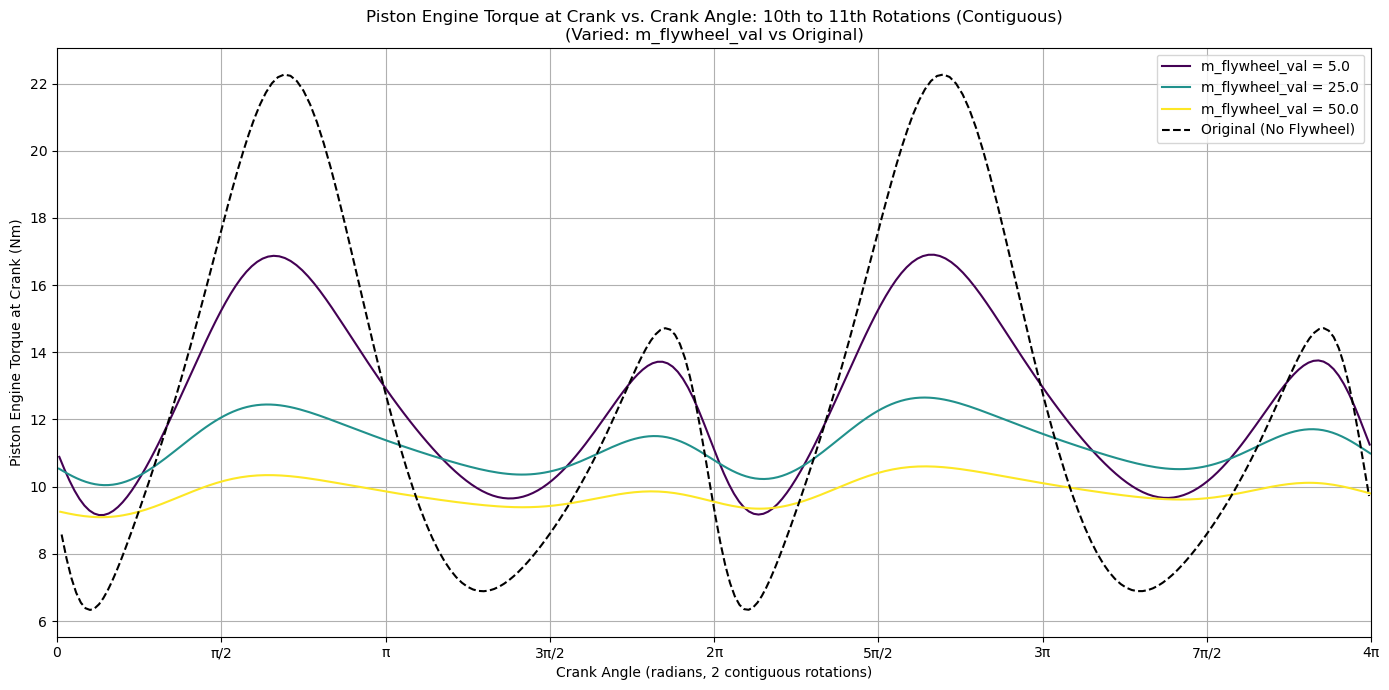

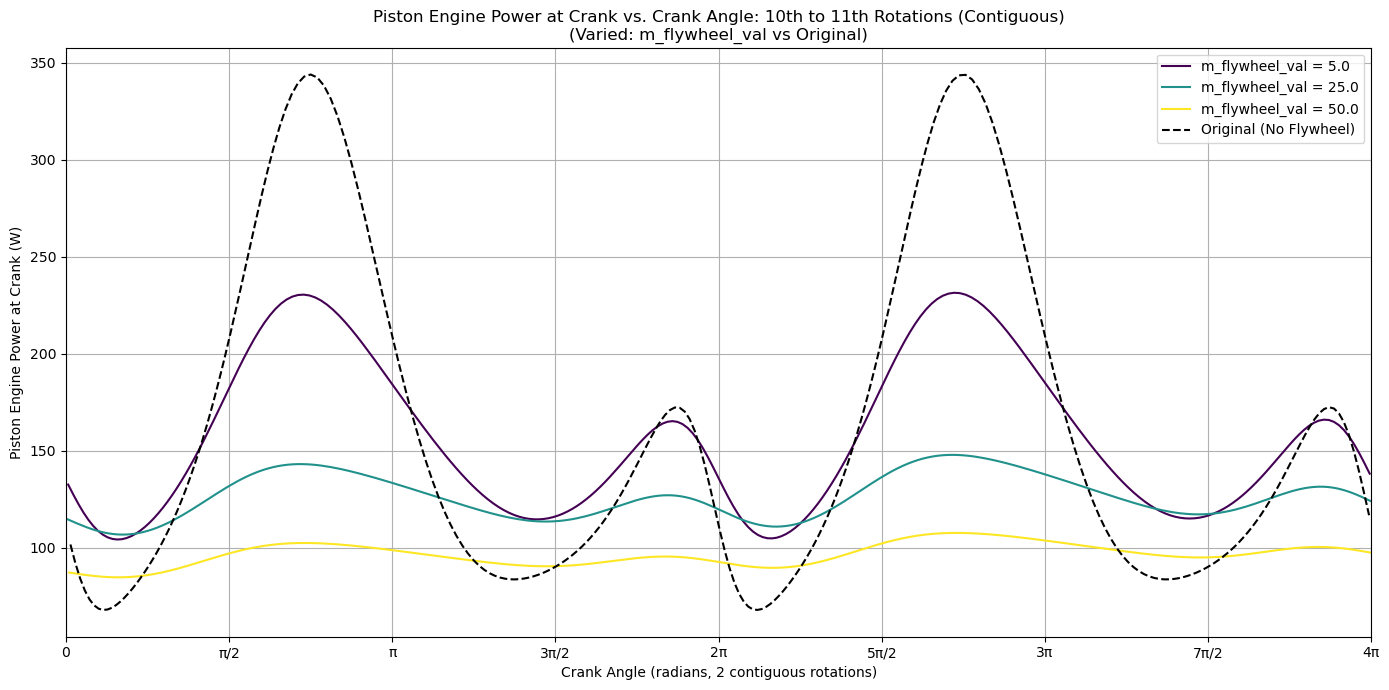

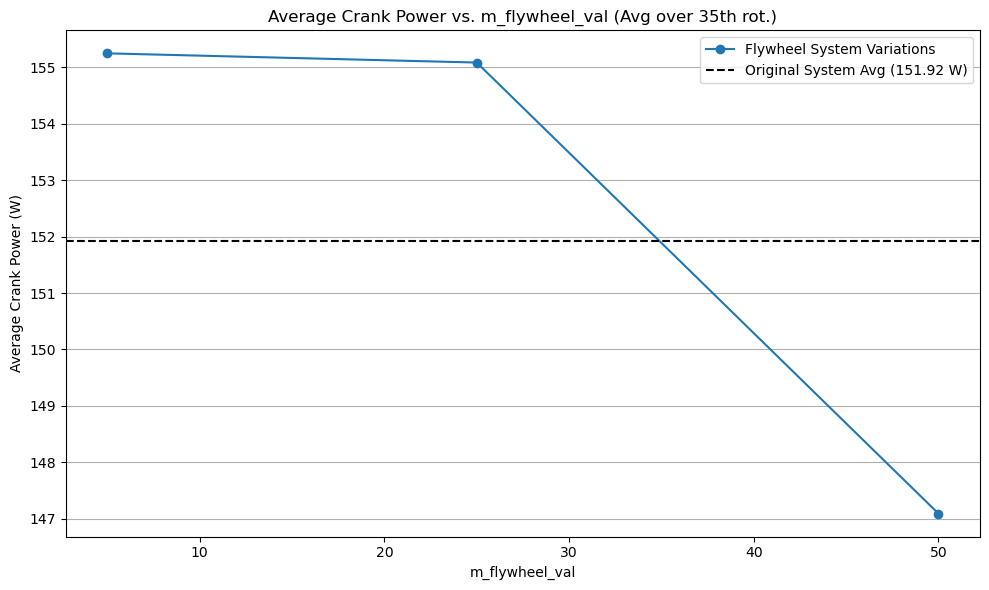


--- Calculating Average Power per Rotation (up to 38) ---
  Processing: m_flywheel_val=5.0
  Processing: m_flywheel_val=25.0
  Processing: m_flywheel_val=50.0
  Processing: Original (No Flywheel)


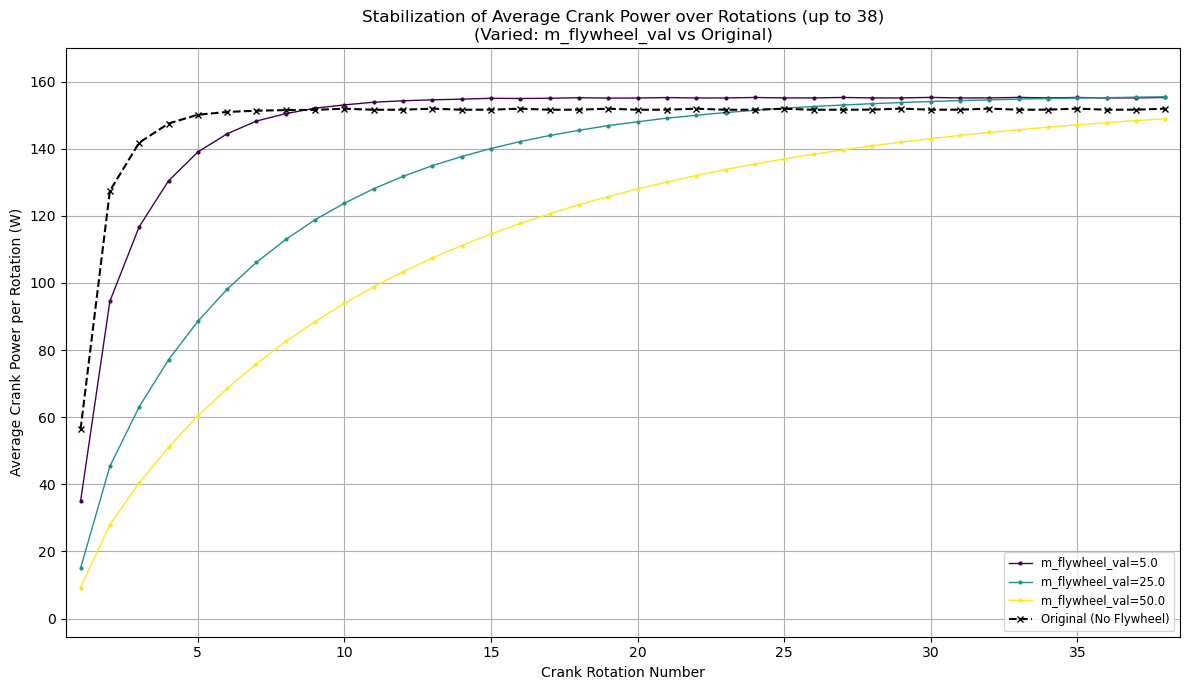


--- Calculating Average Flywheel Stored Energy per Rotation (up to 38) ---
  Processing: m_flywheel_val=5.0 for Flywheel Energy
  Processing: m_flywheel_val=25.0 for Flywheel Energy
  Processing: m_flywheel_val=50.0 for Flywheel Energy
  Processing: Original (No Flywheel) for Flywheel Energy


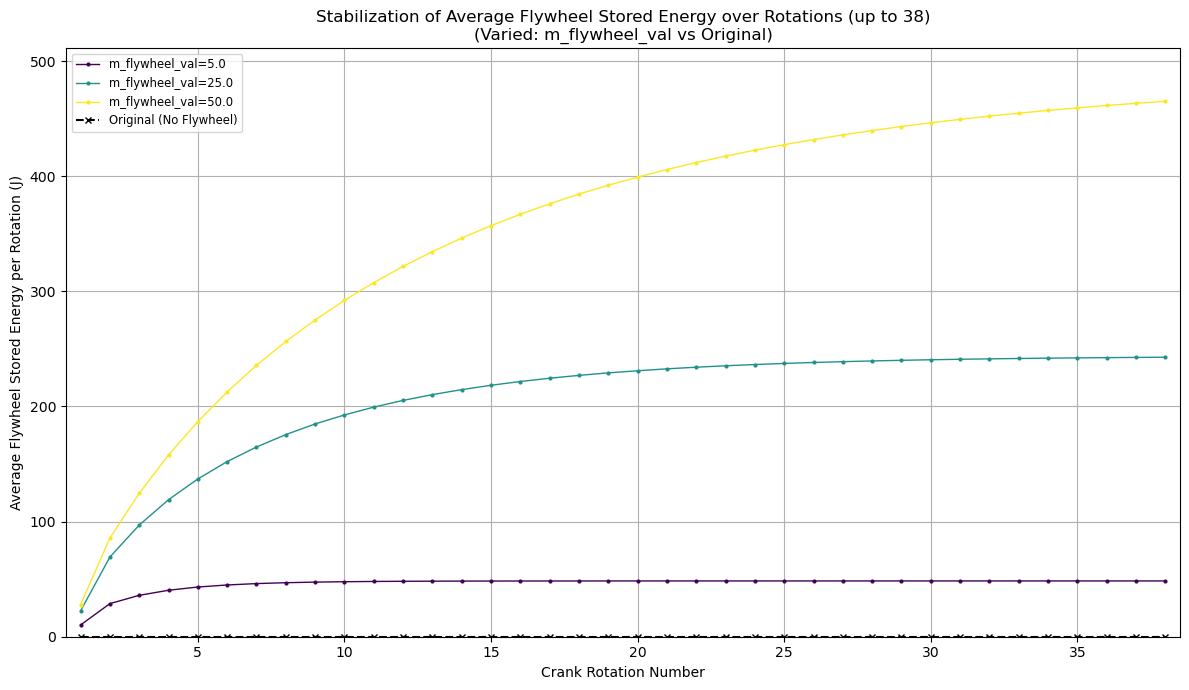

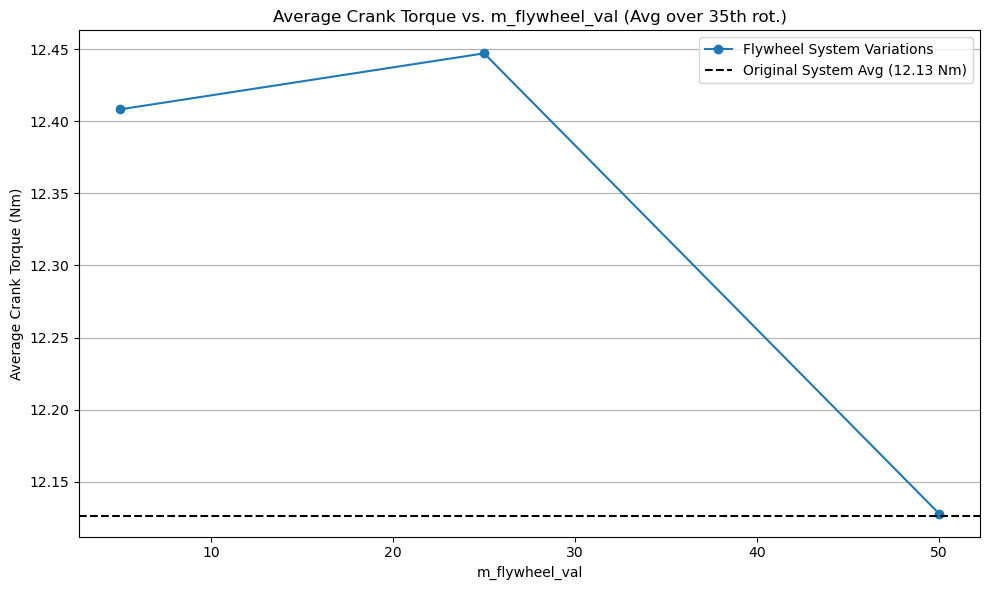

In [16]:
# Cell 16: Execute plotting

if 'all_simulation_results' in globals() and all_simulation_results:
    param_actually_varied = "Unknown"
    first_successful_flywheel_result = next((res for res in all_simulation_results if res.get("success") and res.get("system_type") == "flywheel"), None)
    if first_successful_flywheel_result:
         param_actually_varied = first_successful_flywheel_result['param_varied']
    elif any(res.get("system_type") == "original" for res in all_simulation_results):
         # If only original system ran, param_actually_varied is not from flywheel variation
         param_actually_varied = "N/A (Original System Only)"

    rotations_to_plot_contiguously = [10, 11] 
    rotation_to_average_over = 35 # Adjusted for potentially faster stabilization or shorter sim duration
    max_rotation_for_stabilization_plot = 38 # Adjusted to match typical sim end time (e.g., 40s)

    print(f"\n--- Generating Comparison Plots (Varied: {param_actually_varied}) ---")

    plot_kinematic_vs_crank_angle_contiguous(all_simulation_results, param_actually_varied,
                                             "T_engine_crank", "Engine Torque at Crank", "Nm",
                                             rotations_to_display=rotations_to_plot_contiguously)

    plot_kinematic_vs_crank_angle_contiguous(all_simulation_results, param_actually_varied,
                                             "P_engine_crank", "Engine Power at Crank", "W",
                                             rotations_to_display=rotations_to_plot_contiguously)

    plot_average_metric_vs_parameter(all_simulation_results, param_actually_varied,
                                     "P_engine_crank", "Average Crank Power", "W",
                                     rotation_for_avg=rotation_to_average_over)

    plot_avg_power_vs_rotation(all_simulation_results, param_actually_varied,
                               max_rotation=max_rotation_for_stabilization_plot)
    
    plot_avg_flywheel_energy_vs_rotation(all_simulation_results, param_actually_varied,
                                         max_rotation=max_rotation_for_stabilization_plot)

    plot_average_metric_vs_parameter(all_simulation_results, param_actually_varied,
                                     "T_engine_crank", "Average Crank Torque", "Nm",
                                     rotation_for_avg=rotation_to_average_over)
else:
    print("No simulation results (flywheel or original) to plot. Please run Cell 14 and 14.5 first.")